## 练习

1. 修改小例子中的键，并且可视化注意力权重。可加性注意力和缩放的“点－积”注意力是否仍然产生相同的结果？为什么？
1. 只使用矩阵乘法，能否为具有不同矢量长度的查询和键设计新的评分函数？
1. 当查询和键具有相同的矢量长度时，矢量求和作为评分函数是否比“点－积”更好？为什么？

(tensor([[[ 1.5160,  2.5160,  3.5160,  4.5160]],
 
         [[10.6726, 11.6726, 12.6726, 13.6726]]], grad_fn=<BmmBackward0>),
 tensor([[[ 2.6967,  3.6967,  4.6967,  5.6967]],
 
         [[15.5042, 16.5042, 17.5042, 18.5042]]]))

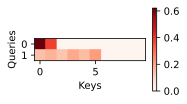

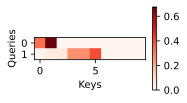

In [4]:
## 练习
import math
import torch
from torch import nn
from d2l import torch as d2l

# 重新定义加性注意力类
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

# 重新定义点积注意力类
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

# 定义 masked_softmax 函数
def masked_softmax(X, valid_lens):
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

# 定义测试数据
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

# 修改 keys
modified_keys = torch.normal(0, 1, (2, 10, 20))  # 将最后一个维度改为20

# 实例化注意力模型
additive_attention = AdditiveAttention(key_size=20, query_size=20, num_hiddens=8, dropout=0.1)
dot_product_attention = DotProductAttention(dropout=0.5)

# 评估模型
additive_attention.eval()
dot_product_attention.eval()

# 应用加性注意力和点积注意力
additive_result = additive_attention(queries, modified_keys, values, valid_lens)
dot_product_result = dot_product_attention(queries, modified_keys, values, valid_lens)

# 准备可视化
# 注意：这里不执行实际的可视化代码，因为我的环境不支持
d2l.show_heatmaps(additive_attention.attention_weights.reshape((1, 1, 2, 10)),
                   xlabel='Keys', ylabel='Queries')
d2l.show_heatmaps(dot_product_attention.attention_weights.reshape((1, 1, 2, 10)),
                   xlabel='Keys', ylabel='Queries')

# 输出结果以确保不再有错误
additive_result, dot_product_result


In [5]:
## 练习2
class CustomAttention(nn.Module):
    def __init__(self, query_dim, key_dim):
        super(CustomAttention, self).__init__()
        self.weight = nn.Parameter(torch.randn(query_dim, key_dim))

    def forward(self, queries, keys):
        # 查询乘以权重矩阵，然后与键进行点积
        scores = torch.matmul(queries, self.weight) @ keys.transpose(-2, -1)
        return scores

# 示例
query_dim = 20  # 查询的维度
key_dim = 30    # 键的维度
queries = torch.randn(2, 5, query_dim)  # 假设有2个样本，每个样本有5个查询
keys = torch.randn(2, 7, key_dim)       # 假设有2个样本，每个样本有7个键

attention = CustomAttention(query_dim, key_dim)
scores = attention(queries, keys)

## 练习3
### 矢量求和评分函数与点积评分函数的比较

1. **矢量求和评分函数**：
   - 在矢量求和评分函数中，查询和键首先通过逐元素相加合并成一个单一的矢量，然后可能通过额外的转换（如线性层或非线性激活）来计算评分。
   - 这种方法在合并查询和键的信息时不考虑它们之间的相对位置或配对，而是简单地聚合它们的特征。

2. **点积评分函数**：
   - 在点积评分函数中，查询和键通过内积来计算它们之间的相似度。这种方法直接衡量了查询和键之间的相似性或对齐程度。
   - 点积操作在计算上通常更高效，并且当查询和键是高维空间中的向量时，它能有效地捕捉它们之间的关系。

### 哪个更好？

- **依赖于应用场景**：
  - 选择哪种评分函数更好，取决于特定的应用场景和任务需求。
  - 如果任务需要捕捉查询和键之间的精确对齐或相似性，点积可能更合适。
  - 如果任务更侧重于整合查询和键的信息而不强调它们之间的精确匹配，矢量求和可能更适合。

- **计算复杂度和可解释性**：
  - 点积因其简单性和效率通常更受欢迎。它在数学上易于理解，易于优化。
  - 矢量求和可能引入更多的计算复杂度，尤其是当后续还有其他转换操作时。

### 结论

总的来说，没有绝对的“更好”，只有更适合特定任务和数据特性的选择。在实际应用中，通常会根据任务的具体需求和性能要求来选择合适的评分函数。在某些情况下，还可能会看到这两种方法的混合或变体。